# Milestone M1b - MR encoding operators

The second deliverable for the **PREDATOR** project Milestone M1 was to develop the basic linear operators describing the MR signal encoding.
Currently, the [DeepMR](https://github.com/INFN-PREDATOR/deep-mr) framework includes the following MR encoding operators:

* **CoilOp**: operator representing the effect of the RF coil profile on received signals. Supports multi-channel RF coil arrays and multiple sets of maps (e.g., for [soft-SENSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4142121/) approaches).
* **FFTop**: operator representing the Fourier encoding for Cartesian sampling. Supports arbitrary sampling masks in dense zero-filled format.
* **SparseFFTop**: operator representing the Fourier encoding for Cartesian sampling. Supports arbitrary sampling masks in sparse COO format.
* **NUFFTop**: operator representing the Fourier encoding for Non-Cartesian sampling. Supports arbitrary non-uniform sampling patterns.

Each operator has been implemented in forward, adjoint and self-adjoint mode, and supports [efficient projection](https://archive.ismrm.org/2022/2771.html) to low-rank subspace (e.g., for model-based dynamic MRI and quantitative MRI). In addition, each operator has been wrapped as a [deepinv.physics.LinearPhysics](https://deepinv.github.io/deepinv/stubs/deepinv.physics.LinearPhysics.html#deepinv.physics.LinearPhysics) model: as this is also a subclass of [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), [DeepMR encoding operators](https://infn-predator.github.io/deep-mr/core/linops.html) can be combined to build Neural Network architectures.

Here, we show two examples (Cartesian and Non-Cartesian imaging, respectively), each consisting in 1) generating a numerical phantom, coil sensitivity profiles and sampling pattern, 2) applying the forward encoding model to generate k-space, 3) applying the adjoint model to obtain a zero-filled representation of the reconstructed image and 4) showcasing the application of self-adjoint for iterative algorithms.

In [2]:
%matplotlib inline
import copy

import numpy as np
import matplotlib.pyplot as plt # for displaying the results

import deepmr

## Example 1: Cartesian Imaging

As a first example, we simulate a Variable-density Poisson-disk subsampled Cartesian MR acquisition. As a first step, we must generate our numerical dataset.

### 1. Generating the dataset

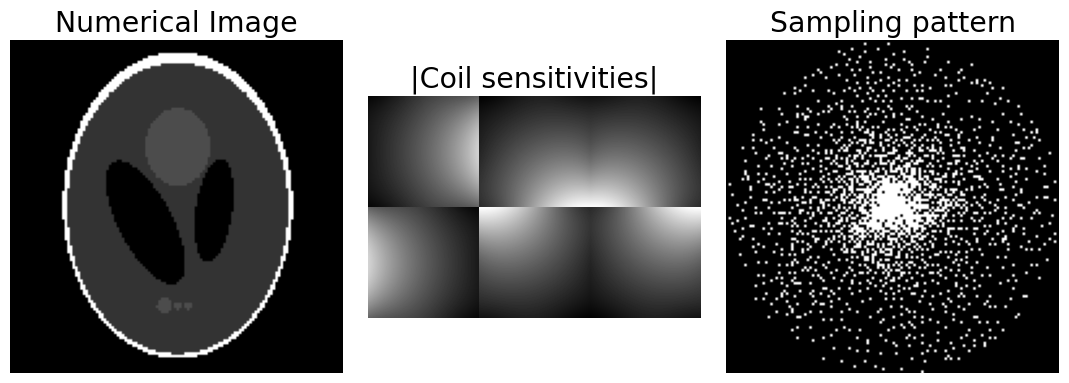

In [3]:
# generate a numerical Shepp-Logan phantom
img0 = deepmr.shepp_logan(128, nslices=1)

# generate coil sensitivity for a 6-channel coil
sensmap = deepmr.sensmap((6, 128, 128))

# generate sampling pattern
# here, we assume we are reconstructing a single slice
# of a 3D acquisition undersampled on (ky, kz) plane
sampmask, _ = deepmr.cartesian3D((128, 128), accel_type="CS", accel=8)
sampmask = sampmask.squeeze()

# plot
plt.rcParams['figure.figsize'] = [11, 4]

# ground truth image
plt.subplot(1, 3, 1)
_ = plt.imshow(img0, cmap="gray")
plt.title("Numerical Image")
plt.axis("off")

# coil sensitivity
plt.subplot(1, 3, 2)

tmp = sensmap.reshape(2, 3, *sensmap.shape[-2:])
tmp = [np.concatenate([tmp[i][j] for j in range(tmp.shape[1])], axis=-1) for i in range(tmp.shape[0])]
tmp = np.concatenate(tmp, axis=0)

_ = plt.imshow(abs(tmp), cmap="gray")
plt.title("|Coil sensitivities|")
plt.axis("off")

# sampling mask
plt.subplot(1, 3, 3)
_ = plt.imshow(sampmask, cmap="gray")
plt.title("Sampling pattern")
plt.axis("off")

plt.tight_layout()

### 2. Forward modeling
Now, we can initialize the operators. Here, we need the Coil and the Cartesian FFT operators:

In [4]:
# coil operator
C = deepmr.linops.CoilOp(2, sensmap[:, None, ...])

# FFT operator
F = deepmr.linops.FFTOp(sampmask[None, ...])


The full encoding operator consists on the application of the sensitivity profiles effect followed by the undersampled FFT:

$$
E(x) = F(C(x))
$$

Thanks to [deepinv.physics.LinearPhysics](https://deepinv.github.io/deepinv/stubs/deepinv.physics.LinearPhysics.html#deepinv.physics.LinearPhysics) (i.e., the base class for [deepmr.linops](https://infn-predator.github.io/deep-mr/core/linops.html), this can be achieved by multiplying the two operators:

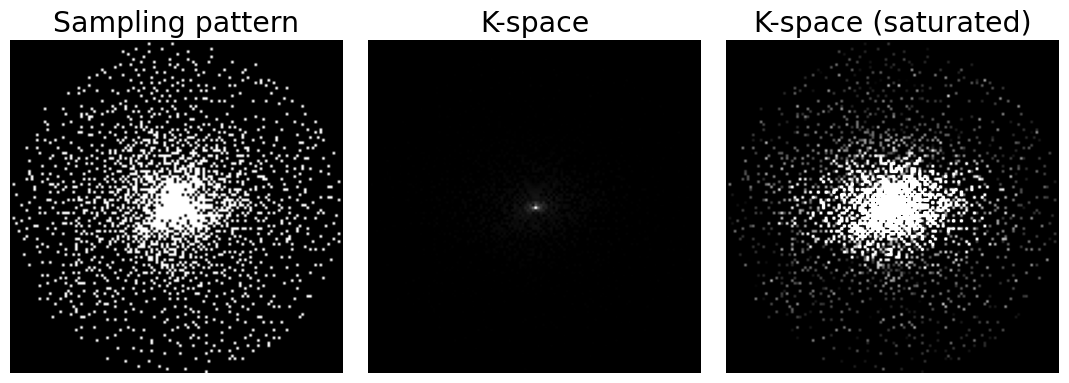

In [5]:
# obtain full encoding
E = F * C

# compute kspace
ksp = E(img0)

# plot
plt.rcParams['figure.figsize'] = [11, 4]

# sampling mask
plt.subplot(1, 3, 1)
_ = plt.imshow(sampmask, cmap="gray")
plt.title("Sampling pattern")
plt.axis("off")

# undersampled kspace
plt.subplot(1, 3, 2)
_ = plt.imshow(abs(ksp[0, 0]), cmap="gray")
plt.title("K-space")
plt.axis("off")

# undersampled kspace
plt.subplot(1, 3, 3)
_ = plt.imshow(abs(ksp[0, 0]), cmap="gray", vmax=0.1)
plt.title("K-space (saturated)")
plt.axis("off")

plt.tight_layout()

Here, first panel summarize again the sampling pattern, the second pattern shows the acquired k-space and the last panel exhibits a saturated colorscale to better delineate the sampling pattern in the acquired k-space.

### 3. Zero-filled reconstruction

We can perform a zero-filled reconstruction by using the adjoint encoding operator:

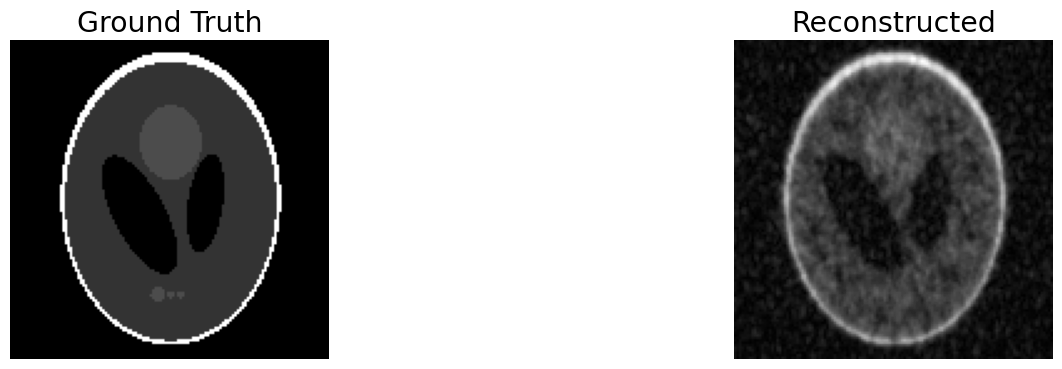

In [6]:
# reconstruct
img = E.H(ksp)

# plot
plt.rcParams['figure.figsize'] = [18, 4]

# ground truth
plt.subplot(1, 2, 1)
_ = plt.imshow(img0, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

# zero-filled
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(img[0, 0]), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()

Compared to the ground truth (left), the zero-filled image (right) in an undersampled acquisition case is corrupted by aliasing which, for a pseudo-random incoherent sampling pattern such as Poisson disk, appears as a noise-like pattern. This can be solved using iterative reconstruction (see Milestone M1c).

### 4. Self-adjoint

For iterative reconstruction, self-adjoint (aka Toeplitz approach) can be more efficient:

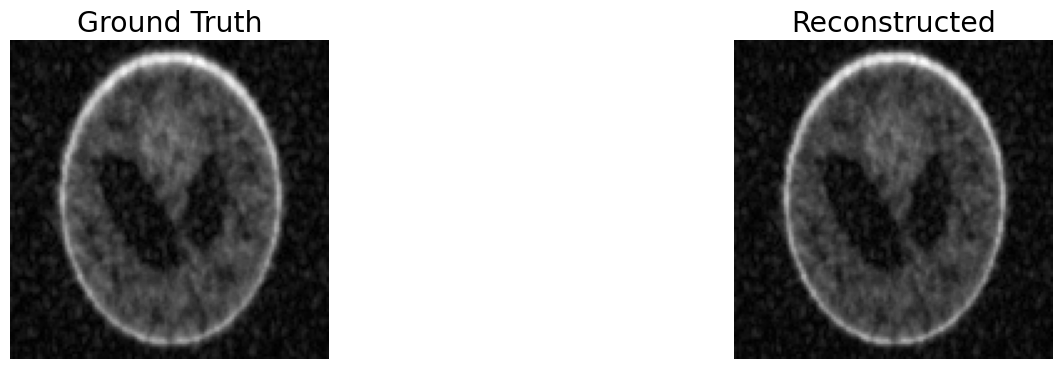

In [7]:
# manual self-adjoint
EHE0 = E.H * E

# build self adjoint
FHF = deepmr.linops.FFTGramOp(sampmask[None, ...])
EHE = C.H * FHF * C

# apply self adjoint
img_selfadjoint0 = EHE0(img)
img_selfadjoint = EHE(img)

# ground truth
plt.subplot(1, 2, 1)
_ = plt.imshow(abs(img_selfadjoint0[0, 0]), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

# zero-filled
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(img_selfadjoint[0, 0]), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()

## Example 2: Non-Cartesian Imaging

As a second example, we simulate a (angular) subsampled Radial MR acquisition. As a first step, we must generate our numerical dataset.

### 1. Generating the dataset

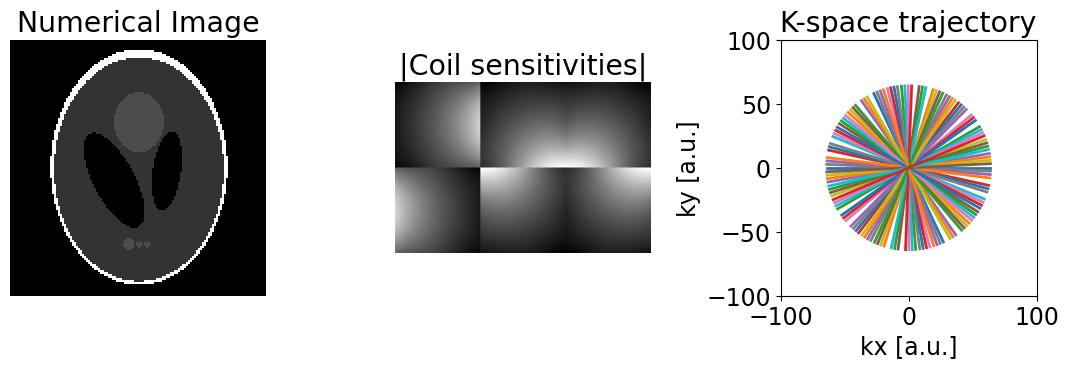

In [33]:
# generate a numerical Shepp-Logan phantom
img0 = deepmr.shepp_logan(128, nslices=1)

# generate coil sensitivity for a 6-channel coil
sensmap = deepmr.sensmap((6, 128, 128))

# generate trajectory
head = deepmr.radial(128, nviews=64)

# plot
plt.rcParams['figure.figsize'] = [11, 4]

# ground truth image
plt.subplot(1, 3, 1)
_ = plt.imshow(img0, cmap="gray")
plt.title("Numerical Image")
plt.axis("off")

# coil sensitivity
plt.subplot(1, 3, 2)

tmp = sensmap.reshape(2, 3, *sensmap.shape[-2:])
tmp = [np.concatenate([tmp[i][j] for j in range(tmp.shape[1])], axis=-1) for i in range(tmp.shape[0])]
tmp = np.concatenate(tmp, axis=0)

_ = plt.imshow(abs(tmp), cmap="gray")
plt.title("|Coil sensitivities|")
plt.axis("off")

# trajectory
plt.subplot(1, 3, 3)
_ = plt.plot(head.traj[0, :, :, 0].T, head.traj[0, :, :, 1].T)
plt.axis("square")
plt.ylim([-100, 100])
plt.xlim([-100, 100])
_ = plt.title("K-space trajectory")
_ = plt.xlabel("kx [a.u.]"), plt.ylabel("ky [a.u.]")
plt.tight_layout()

plt.tight_layout()

### 2. Forward modeling
Now, we can initialize the operator and perform the forward steps. Here, we need the Coil and theNon-Uniformn FFT(NUFFT)  operators:

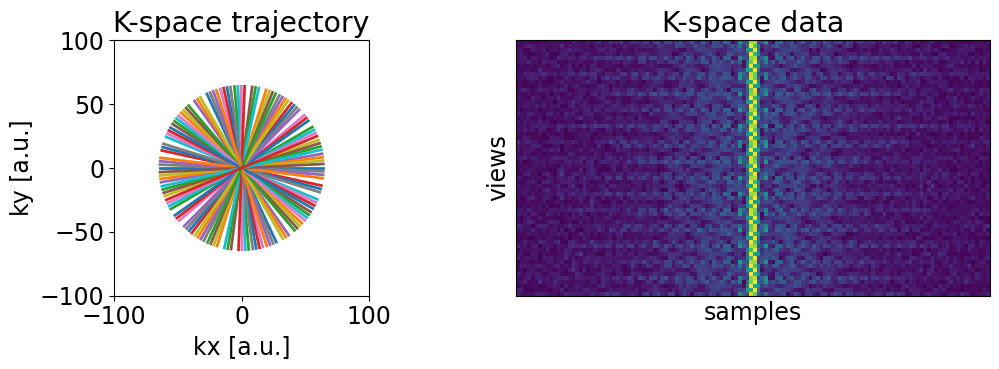

In [37]:
# coil operator
C = deepmr.linops.CoilOp(2, sensmap[:, None, ...])

# FFT operator
F = deepmr.linops.NUFFTOp(head.traj, head.shape[-2:], weight=head.dcf)

# obtain full encoding
E = F * C

# compute kspace
ksp = E(img0)

# plot
plt.rcParams['figure.figsize'] = [11, 4]

# trajectory
plt.subplot(1, 2, 1)
_ = plt.plot(head.traj[0, :, :, 0].T, head.traj[0, :, :, 1].T)
plt.axis("square")
plt.ylim([-100, 100])
plt.xlim([-100, 100])
_ = plt.title("K-space trajectory")
_ = plt.xlabel("kx [a.u.]"), plt.ylabel("ky [a.u.]")

# raw data
plt.rcParams['figure.figsize'] = [11, 4]
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(ksp[0, 0]), aspect='auto')
plt.title("K-space data")
plt.xticks([]),plt.yticks([])
_ = plt.xlabel("samples")
_ = plt.ylabel("views")

plt.tight_layout()


### 3. Zero-filled reconstruction

As in the Cartesian case, we can perform a zero-filled reconstruction by using the adjoint encoding operator:

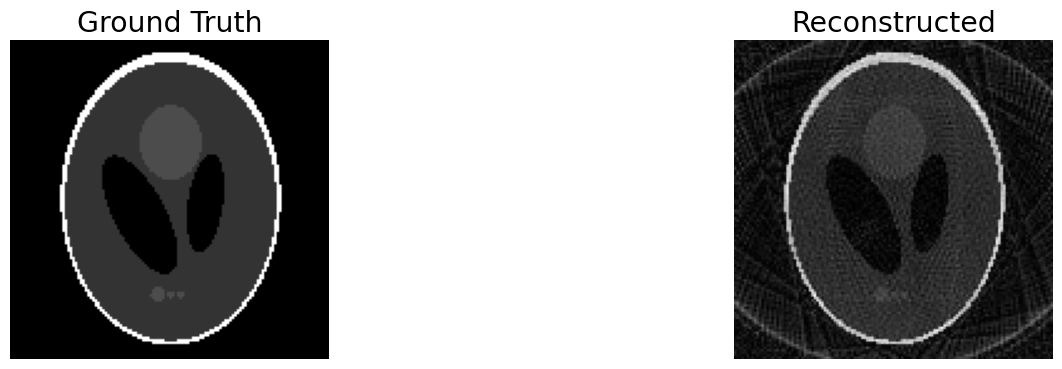

In [38]:
# reconstruct
img = E.H(ksp)

# plot
plt.rcParams['figure.figsize'] = [18, 4]

# ground truth
plt.subplot(1, 2, 1)
_ = plt.imshow(img0, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

# zero-filled
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(img[0, 0]), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()

Again, when compared to the ground truth (left), the zero-filled image (right) in an undersampled acquisition case is corrupted by aliasing which, for a Non-Cartesian radial sampling pattern, appears as a streaking artifact. As in the Cartesian case, this can be solved using iterative reconstruction (see Milestone M1c).

### 4. Self-adjoint

For iterative reconstruction, self-adjoint (aka Toeplitz approach) can be more efficient (even more than in Cartesian case):

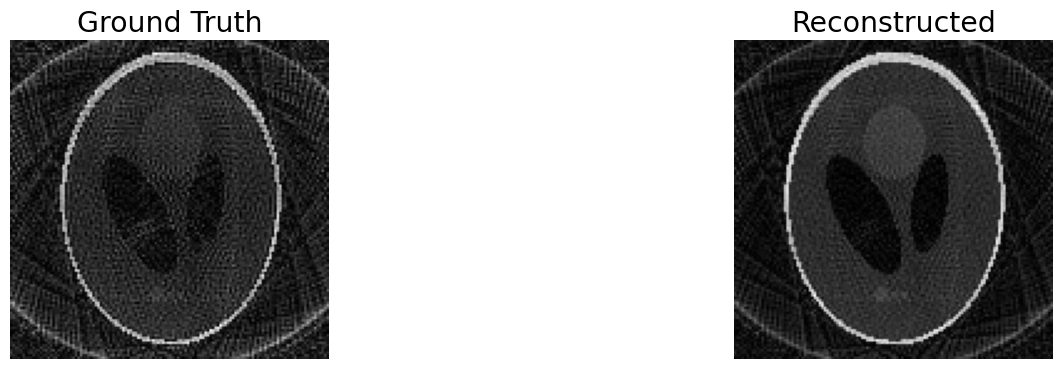

In [40]:
# manual self-adjoint
EHE0 = E.H * E

# build self adjoint
FHF = deepmr.linops.FFTGramOp(sampmask[None, ...])
EHE = C.H * FHF * C

# apply self adjoint
img_selfadjoint0 = EHE0(img)
img_selfadjoint = EHE(img)

# ground truth
plt.subplot(1, 2, 1)
_ = plt.imshow(abs(img_selfadjoint0[0, 0]), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

# zero-filled
plt.subplot(1, 2, 2)
_ = plt.imshow(abs(img_selfadjoint[0, 0]), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()